In [3]:
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

link = 'https://silverconnect.silverstatecu.com/dbank/live/app/home/frame?src=%2Fpfm%2Flive%2Fpfmweb%2Fhome'

# driver = webdriver.Chrome()

# driver.get(link)  
# removed automation step where dataframe is scraped from bank website, github is public

<h2>Data Cleansing</h2>

In [4]:
ogdata = pd.read_csv('transactions 12.4.csv')

# narrowing in on just my checking account
ogdata = ogdata[ogdata['Account'] != 'INSURED MONEY MARKET']
ogdata = ogdata[ogdata['Description'] != 'Transfer from Account 50']
ogdata = ogdata[ogdata['Description'] != 'Transfer to Share']

# data cleansing/validation
ogdata = ogdata.fillna(0)

# data type validation
ogdata['Amount'] = ogdata['Amount'].astype(float)
ogdata['Date']= pd.to_datetime(ogdata['Date'])
ogdata['Month'] = ogdata['Date'].dt.month
ogdata['Year'] = ogdata['Date'].dt.year

# data = ogdata.groupby(by=['Description','Type'],as_index = False).agg({'Amount':'sum','Date':'count'})
# assigns unknown parent types as shopping when the description contains "signature base"
ogdata.loc[
    (ogdata['Description'].str.contains('signature base', case=False, na=False)) &
    (ogdata['Parent Category'] == 'Uncategorized'),
    'Parent Category'
] = 'Shopping'


C:\Users\caesa\AppData\Local\Temp\ipykernel_21432\1558460626.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ogdata['Date']= pd.to_datetime(ogdata['Date'])


<h2>Data Manipulation</h2>

In [5]:
# get list of paycheck dates, using employer as the unique identifier
time = ogdata[ogdata['Description'] == 'Resorts Inte']

# grabs the index of each paycheck, assigns this to the 'pay_period' column
time = time.reset_index()
time['pay_period'] = time.index
time

# match indexed paycheck dates to the rest of the bank statements
df = ogdata.merge(time, how='left')

# assigns all entries after a paycheck but before the next one as part of its paycheck period
values = []

# initiates loop
for i in range(int(df['pay_period'].max())+1):
#   grabs the index from the original transactions dataframe
    val = df.index[df['pay_period'] == i].tolist()
    
#   adds this value to the earlier list
    values += val
#   for most recent pay period(not fully complete), assigns each value for pay_period as 0
    if i == 0:    
        # df.loc[(df.index>0) & (df.index <= val),'pay_period'] = i
        df.loc[(df.index>=0)&(df.index < values[i]),'pay_period'] = i
#   for every other pay period, 
    else:
        df.loc[(df.index>values[i-1]) & (df.index <= values[i]),'pay_period'] = i

# now, separate paycheck periods can be compared to each other

,index,Date,Description,Original Description,Amount,Type,Parent Category,Category,Account,Tags,Memo,Pending,Month,Year,pay_period
0,34,2024-11-27,Resorts Inte,Deposit MGM RESORTS INTE / TYPE: PAYROLL ID:...,2072.45,Credit,Income,Paycheck,MYACCOUNT CHECKING,0.0,TYPE: PAYROLL ID: 4880471660 DATA: 0000000000...,False,11,2024,0
1,101,2024-11-13,Resorts Inte,Deposit MGM RESORTS INTE / TYPE: PAYROLL ID:...,2072.46,Credit,Income,Paycheck,MYACCOUNT CHECKING,0.0,TYPE: PAYROLL ID: 4880471660 DATA: 0000000000...,False,11,2024,1
2,163,2024-10-30,Resorts Inte,Deposit MGM RESORTS INTE / TYPE: PAYROLL ID:...,2072.45,Credit,Income,Paycheck,MYACCOUNT CHECKING,0.0,TYPE: PAYROLL ID: 4880471660 DATA: 0000000000...,False,10,2024,2
3,227,2024-10-16,Resorts Inte,Deposit MGM RESORTS INTE / TYPE: PAYROLL ID:...,2072.46,Credit,Income,Paycheck,MYACCOUNT CHECKING,0.0,TYPE: PAYROLL ID: 4880471660 DATA: 0000000000...,False,10,2024,3
4,286,2024-10-02,Resorts Inte,Deposit MGM RESORTS INTE / TYPE: PAYROLL ID:...,2072.45,Credit,Income,Paycheck,MYACCOUNT CHECKING,0.0,TYPE: PAYROLL ID: 4880471660 DATA: 0000000000...,False,10,2024,4
5,343,2024-09-18,Resorts Inte,Deposit MGM RESORTS INTE / TYPE: PAYROLL ID:...,2072.45,Credit,Income,Paycheck,MYACCOUNT CHECKING,0.0,TYPE: PAYROLL ID: 4880471660 DATA: 0000000000...,False,9,2024,5
6,390,2024-09-04,Resorts Inte,Deposit MGM RESORTS INTE / TYPE: PAYROLL ID: 4...,2072.45,Credit,Income,Paycheck,MYACCOUNT CHECKING,0.0,TYPE: PAYROLL ID: 4880471660 DATA: 00000000000...,False,9,2024,6
7,429,2024-08-21,Resorts Inte,Deposit MGM RESORTS INTE / TYPE: PAYROLL ID: 4...,2072.46,Credit,Income,Paycheck,MYACCOUNT CHECKING,0.0,TYPE: PAYROLL ID: 4880471660 DATA: 00000000000...,False,8,2024,7
8,458,2024-08-07,Resorts Inte,Deposit MGM RESORTS INTE / TYPE: PAYROLL ID: 4...,2072.56,Credit,Income,Paycheck,MYACCOUNT CHECKING,0.0,TYPE: PAYROLL ID: 4880471660 DATA: 00000000000...,False,8,2024,8
9,498,2024-07-24,Resorts Inte,Deposit MGM RESORTS INTE / TYPE: PAYROLL ID: 4...,1080.68,Credit,Income,Paycheck,MYACCOUNT CHECKING,0.0,TYPE: PAYROLL ID: 4880471660 DATA: 00000000000...,False,7,2024,9


In [4]:
df[30:45]

,Date,Description,Original Description,Amount,Type,Parent Category,Category,Account,Tags,Memo,Pending,Month,Year,index,pay_period
30,2024-11-29,Chase Credit Card,Withdrawal CHASE CREDIT CRD / TYPE: AUTOPAY ...,201.04,Debit,Transfer,Credit Card Payment,MYACCOUNT CHECKING,0.0,TYPE: AUTOPAY ID: 4760039224 CO: CHASE CREDIT...,False,11,2024,NaN,0.0
31,2024-11-28,Chevron,Withdrawal Signature base / CHEVRON 0380732 L...,4.00,Debit,Auto & Transport,Gas,MYACCOUNT CHECKING,0.0,CHEVRON 0380732 LAS VEGAS NV Date 11/27/24 246...,False,11,2024,NaN,0.0
32,2024-11-28,Chevron,Withdrawal Signature base / CHEVRON 0380732 L...,2.29,Debit,Auto & Transport,Gas,MYACCOUNT CHECKING,0.0,CHEVRON 0380732 LAS VEGAS NV Date 11/28/24 246...,False,11,2024,NaN,0.0
33,2024-11-27,Resorts Inte,Deposit MGM RESORTS INTE / TYPE: PAYROLL ID:...,2072.45,Credit,Income,Paycheck,MYACCOUNT CHECKING,0.0,TYPE: PAYROLL ID: 4880471660 DATA: 0000000000...,False,11,2024,34.0,0.0
34,2024-11-27,Costco Gas,Withdrawal #433215199918 / COSTCO GAS #0737 L...,47.03,Debit,Auto & Transport,Gas,MYACCOUNT CHECKING,0.0,COSTCO GAS #0737 LAS VEGAS NV %% Card 25 #6756...,False,11,2024,NaN,1.0
35,2024-11-27,Costco,Withdrawal #433215372315 / COSTCO WHSE #0737 ...,11.53,Debit,Shopping,Shopping,MYACCOUNT CHECKING,0.0,COSTCO WHSE #0737 LAS VEGAS NV %% Card 25 #675...,False,11,2024,NaN,1.0
36,2024-11-27,Chevron,Withdrawal Signature base / CHEVRON 0356663 L...,17.79,Debit,Food & Dining,Fast Food,MYACCOUNT CHECKING,0.0,CHEVRON 0356663 LAS VEGAS NV Date 11/27/24 246...,False,11,2024,NaN,1.0
37,2024-11-27,Transfer to Apple Pay,Withdrawal Signature base / APPLE CASH SENT M...,30.00,Debit,Transfer,Transfer,MYACCOUNT CHECKING,0.0,APPLE CASH SENT MONEY 1INFINITELOOP CA Date 11...,False,11,2024,NaN,1.0
38,2024-11-27,Burger King,Withdrawal Signature base / BURGER KING #1562...,6.48,Debit,Food & Dining,Fast Food,MYACCOUNT CHECKING,0.0,BURGER KING #15624 Q07 LAS VEGAS NV Date 11/25...,False,11,2024,NaN,1.0
39,2024-11-26,GameStop,Withdrawal #433202340776 / GAMESTOP #5538 791...,138.10,Debit,Shopping,Electronics & Software,MYACCOUNT CHECKING,0.0,GAMESTOP #5538 7910 W T LAS VEGAS NV %% Card 2...,False,11,2024,NaN,1.0


<h2>Moving Paycheck Comparison</h2>

In [5]:
# get first ever date found in the list of paychecks
dates = df['Date']
earliest_date = dates.sort_values(ascending=True).dt.date.iloc[0]

# filtering to the latest complete pay period
paycheck_date = df[df['pay_period'] == 1]['Date']

# gets beginning and end date for the paycheck period
earliest = paycheck_date.sort_values(ascending=True).dt.date.iloc[0]
latest = paycheck_date.sort_values(ascending=True).dt.date.iloc[-1]

print(f'For the pay period starting on {earliest} and ending on {latest}')
print('--------------------------------------------------------------------------')

# groups by spend type
periodicaldata = df.groupby(['pay_period','Type','Parent Category'],as_index=False).agg({'Amount':pd.Series.sum,'Date':pd.Series.min})

# gets total earned money by pay period, which is a credit
earn = periodicaldata[periodicaldata['Type'] != 'Debit']
earn = earn.groupby('pay_period', as_index=False).agg({'Amount':pd.Series.sum})

# grabs value from the new dataframe
last_paycheck_earn = earn.iloc[1,1]

# presents the total earned money made within the pay cycle
total_spend = (f'Last pay cycle you made ${round(last_paycheck_earn,2)}')
print(total_spend)

last_cycle_earn = df[(df['pay_period'] == 1.) & (df['Type'] == 'Credit')]
earn_entries = last_cycle_earn.sort_values('Amount',ascending=False)

# gets total spend by pay period
spend = periodicaldata[periodicaldata['Type'] != 'Credit']
spend = spend.groupby('pay_period', as_index=False).agg({'Amount':pd.Series.sum})

# spend during this pay period
last_paycheck_spend = spend.iloc[1,1]
paycheck_prior = spend.iloc[2,1]

# grabs the lift paycheck over paycheck in terms of spend
variance_pct = round(((last_paycheck_spend-paycheck_prior)/paycheck_prior)*100,2)

# adding context
spend = spend.sort_values('Amount',ascending = False)
spend = spend.reset_index()
spend['index'] = spend.index
spend
result = spend[spend['pay_period'] == 1]['index']+1
ranking = result.iloc[0]
num_pay_periods = len(spend)

total_spend = (f'Last pay cycle you spent ${round(last_paycheck_spend,2)}, a lift of {variance_pct}% over the prior period')
print(f'\tThis ranked {ranking}/{num_pay_periods} in terms of biweekly spend since {earliest_date}\n')
print(total_spend)
spend[:30]

last_variance = last_paycheck_earn - last_paycheck_spend

last_cycle = df[(df['pay_period'] == 1.) & (df['Type'] == 'Debit')]
print(f'\tThis means that you kept ${round(last_variance,2)}')
print('--------------------------------------------------------------------------\n')
print('These were the 10 biggest purchases')
top10 = last_cycle.sort_values('Amount', ascending=False)[:10]
top10 = top10[['Date','Description','Memo','Amount','Parent Category','Category']]

top10


For the pay period starting on 2024-11-13 and ending on 2024-11-27
--------------------------------------------------------------------------
Last pay cycle you made $4847.46
	This ranked 3/10 in terms of biweekly spend since 2024-06-02

Last pay cycle you spent $2841.72, a lift of 72.96% over the prior period
	This means that you kept $2005.74
--------------------------------------------------------------------------

These were the 10 biggest purchases


,Date,Description,Memo,Amount,Parent Category,Category
70,2024-11-21,Transfer to Venmo,TYPE: PAYMENT ID: 3264681992 CO: VENMO NAME:...,600.00,Transfer,Transfer
49,2024-11-25,Apple Credit Card,TYPE: PAYMENT ID: 9999999999 CO: APPLECARD GS...,461.08,Transfer,Credit Card Payment
55,2024-11-24,Signature Base Bellagio Lago,BELLAGIO - LAGO LAS VEGAS NV Date 11/24/24 246...,305.72,Food & Dining,Restaurants
53,2024-11-24,Signature Base Lockerroombylids,LockerRoomByLids 8198 Las Vegas NV Date 11/25/...,150.10,Shopping,Uncategorized
39,2024-11-26,GameStop,GAMESTOP #5538 7910 W T LAS VEGAS NV %% Card 2...,138.10,Shopping,Electronics & Software
76,2024-11-18,Signature Base Stag Provisions,SP STAG PROVISIONS 151-29393911 TX Date 11/18/...,62.28,Shopping,Clothing
62,2024-11-22,Zelle Transfer to Jayleen Astorga,ZEL*JAYLEEN ASTORGA Visa Direct AZ Date 11/23/...,53.00,Transfer,Transfer
86,2024-11-17,Signature Base Diceys Tavern Nas,TST*DICEYS TAVERN - NAS Nashville TN Date 11/1...,52.17,Food & Dining,Alcohol & Bars
54,2024-11-24,Signature Base Dickies,Dickies 107 Las Vegas NV Date 11/25/24 2479338...,47.69,Shopping,Uncategorized
34,2024-11-27,Costco Gas,COSTCO GAS #0737 LAS VEGAS NV %% Card 25 #6756...,47.03,Auto & Transport,Gas


<h2>Net Income Over Pay Period </h2>

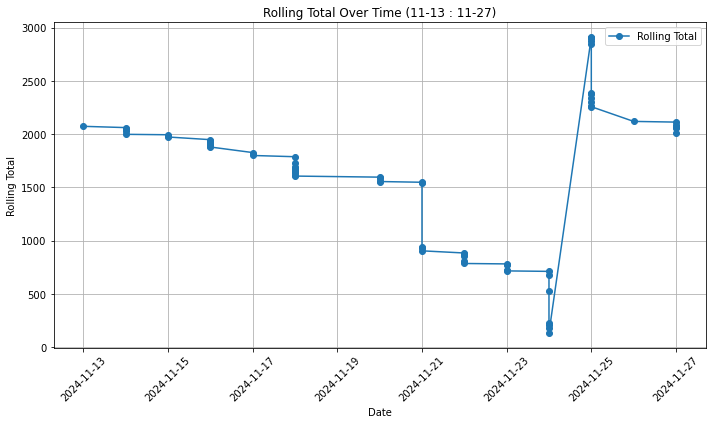

In [6]:
# getting a visual of how the net income varies over the course of the paycheck
period_trends = df[df['pay_period'] == 1 ].sort_values('Date',ascending=True)

# period_trends = df.sort_values('Date',ascending=True)

# converts all debit type amounts to negative
period_trends.loc[period_trends['Type'] == 'Debit', 'Amount'] *= -1

# get the dataframe ready for plt
period_trends = period_trends[['Date','Amount']]
period_trends['Date'] = pd.to_datetime(period_trends['Date'])


# calculate rolling total (cumulative sum)
period_trends['Rolling Total'] = period_trends['Amount'].cumsum()

# converts both data types to a form which can 
dates = period_trends['Date'].to_numpy()
rolling_totals = period_trends['Rolling Total'].to_numpy()

# plot the rolling total
plt.figure(figsize=(10, 6))
plt.plot(dates, rolling_totals, marker='o', label='Rolling Total')
plt.title('Rolling Total Over Time ('+str(earliest.month)+'-'+str(earliest.day)+' : '+str(latest.month)+'-'+str(latest.day)+')')
plt.xlabel('Date')
plt.ylabel('Rolling Total')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

img = plt.show()
# consistent with findings from prior cell

<h2>Proportion of Spend by Category </h2>

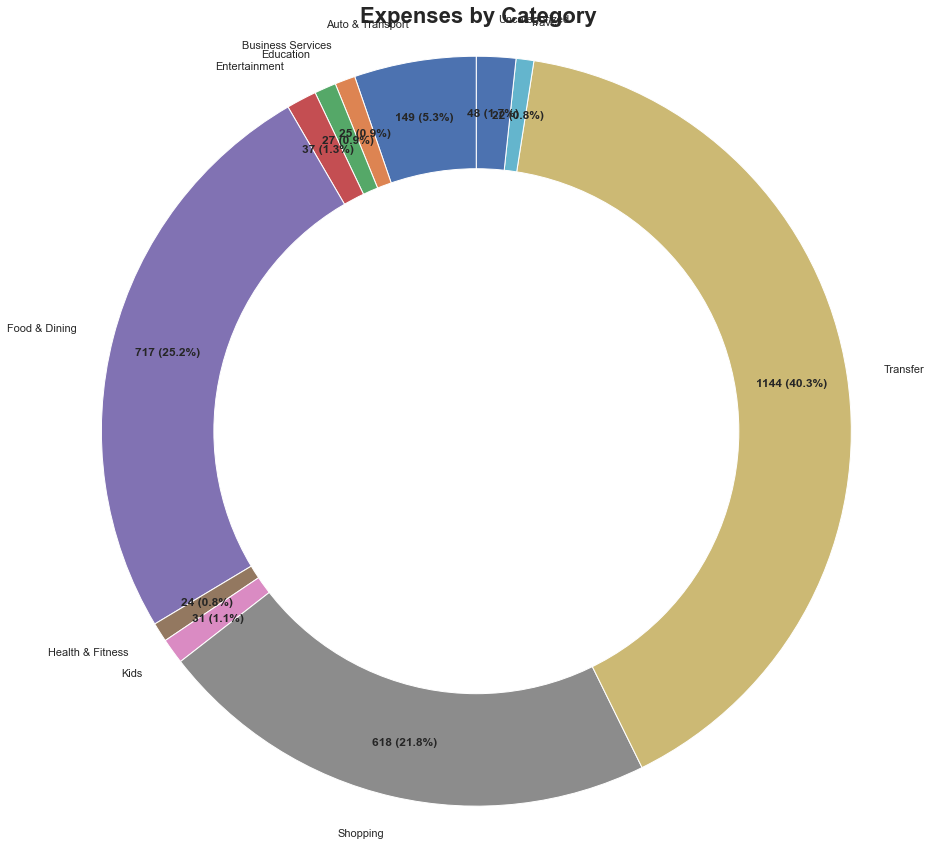

In [7]:
# getting percentage of spend by category
# specifying most recent pay period
last_paycheck = df[df['pay_period']==1]

# only expenses, aggregate amounts
last_paycheck_expenses = last_paycheck[last_paycheck['Type'] == 'Debit']
lpe_grouped = last_paycheck_expenses.groupby(['Parent Category'],as_index=False).agg({'Amount':pd.Series.sum})
lpe_grouped
# last_paycheck[last_paycheck['Parent Category'] == 'Food & Dining']

# seaborn styling
sns.set_theme(style="whitegrid")

# used to showcase absolute numbers as well as pct of whole
def format_autopct(pct, all_values):
    absolute = int(round(pct / 100.0 * sum(all_values))) 
    return f"{absolute} ({pct:.1f}%)" 

# specifies size of pie chart, bigger due to small categories
fig, ax = plt.subplots(figsize=(15, 15)) 
# gets wedges of the donut chart, titles, displays
wedges, texts, autotexts = ax.pie(
    lpe_grouped['Amount'],
    labels=lpe_grouped['Parent Category'],
    autopct=lambda pct: format_autopct(pct, lpe_grouped['Amount']),  # Custom format function
    startangle=90,
#   makes sure that percentages are closer to the center for ease of reading
    pctdistance=0.85, 
)

# makes it a donut chart
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(center_circle)

# other appearance attributes
ax.axis('equal') 
plt.setp(autotexts, size=12, weight="bold") 
plt.title("Expenses by Category", fontsize=22, weight="bold") 

# displays chart
plt.show()

<h2> Spend Category Movement </h2>

In [8]:
# filter based on spend, trying to get category spend by pay period
pivot_data = df[df['Type'] == 'Debit']
pivot_table = pivot_data.pivot_table(
    index="Parent Category",  
    columns="pay_period",     
    values="Amount",          
    aggfunc="sum",            
    fill_value=0              
)

# renaming columns for clarity
pivot_table.columns = [f"Pay Period {int(col)}" for col in pivot_table.columns]

# resetting index for a cleaner table
pivot_table = pivot_table.reset_index()

# calculating variance
pivot_table['last_paycheck_variance'] = pivot_table['Pay Period 1'] - pivot_table['Pay Period 2']

# calculating lift
pivot_table['percentage_variance'] = 100*(pivot_table['last_paycheck_variance']/pivot_table['Pay Period 2'])

# only comparing the categories that had spend across the two pay periods
pivot_table = pivot_table[(pivot_table['Pay Period 1'] > 0) & (pivot_table['Pay Period 2'] > 0)]

# see which categories increased the most in terms of total spend
pivot_table = pivot_table.sort_values('last_paycheck_variance',ascending = False)

top_3_categories = pivot_table.iloc[:3,0]

pivot_table.set_index('Parent Category',inplace = True)

pivot_table.iloc[:,1:]
# pivot_table.iloc[:2,0]
# top categories were Transfer, Food & Dining, and Shopping
# based on this, I spent more in this paycheck period in every category except auto & transport and Travel

,Pay Period 1,Pay Period 2,Pay Period 3,Pay Period 4,Pay Period 5,Pay Period 6,Pay Period 7,Pay Period 8,Pay Period 9,last_paycheck_variance,percentage_variance
Parent Category,,,,,,,,,,,
Transfer,1144.08,477.26,851.57,82.00,246.31,1464.83,511.83,773.00,1087.41,666.82,139.718392
Food & Dining,716.62,253.48,226.29,289.27,306.40,285.22,175.68,245.63,102.97,463.14,182.712640
Shopping,618.25,358.34,368.41,728.17,646.05,326.17,850.50,36.83,272.77,259.91,72.531674
Uncategorized,48.04,10.25,140.50,30.00,327.94,333.77,208.60,308.99,565.99,37.79,368.682927
Entertainment,36.99,7.99,0.00,122.19,0.00,11.99,313.94,40.49,103.64,29.00,362.953692
Auto & Transport,149.48,291.01,100.63,210.37,25.24,106.17,21.84,31.23,29.86,-141.53,-48.634068
Travel,21.72,212.09,9.99,0.00,9.99,0.00,0.00,1.00,0.00,-190.37,-89.759065


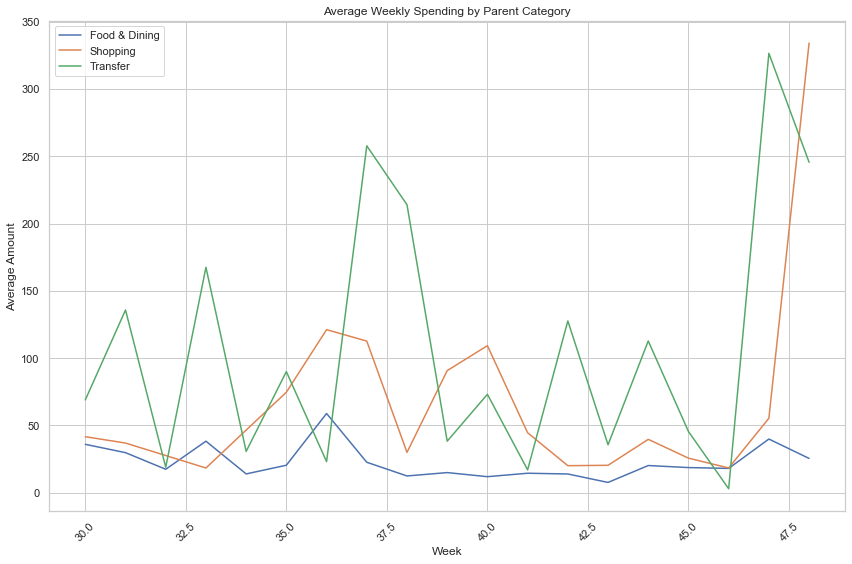

In [9]:
# filters df to only get the actualized pay periods and for only the categories specified as the biggest movers in the most recent
df = df[df['pay_period'] > 0]
df = df[df['Parent Category'].isin(top_3_categories)]

# data validation
df['Date'] = pd.to_datetime(df['Date'])

# getting week number to average spend by week, makes for a cleaner visual
df['Week'] = df['Date'].dt.isocalendar().week
df['Year'] = df['Date'].dt.year

# groups by year, week, and spend category, gets the mean of amount for each week
weekly_avg = df.groupby(['Year', 'Week', 'Parent Category'])['Amount'].mean().reset_index()

# sets up lplot
plt.figure(figsize=(12, 8))

# creates a separate plot for each spend category
for category in weekly_avg['Parent Category'].unique():
    # filters for only the specified category
    category_data = weekly_avg[weekly_avg['Parent Category'] == category]
    
    #converts to arrays to prevent errors
    weeks = category_data['Week'].to_numpy()
    amounts = category_data['Amount'].to_numpy()
    
    # plots average spend amount across week
    plt.plot(weeks, amounts, label=category)

# adds labels and title
plt.xlabel('Week')
plt.ylabel('Average Amount')
plt.title('Average Weekly Spending by Parent Category')

# shows legend
plt.legend()

# Rotate date labels for better visibility (if needed)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

<h2>Conclusion: Holiday Shopping is Real </h2>